In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.utils import shuffle
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ROCAUC, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('lyrics.csv')
model_score = []

In [3]:
for i in range(len(data)):
    data['Lyrics'][i] = data['Lyrics'][i].replace(" \'", " ").replace("\',", "\n ").replace("\\", " ")[2:-1]
    data['Lyrics'][i] = data['Lyrics'][i].replace("\"", " ").replace('"', ' ').replace(".", " ").replace("!", " ").replace("?", " ")
    data['Lyrics'][i] = re.sub(r'\[{1}[^\]]+\]{1}', '', data['Lyrics'][i])
    data['Lyrics'][i] = data['Lyrics'][i].replace("\n", "").replace(",", " ").replace("(", " ").replace(")", " ")
    data['Lyrics'][i] = data['Lyrics'][i].lower()


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['Lyrics'], data['Genre'], test_size=0.33, random_state=42)

In [5]:
# Train model using CountVectorizer

# define our model
text_clf = Pipeline(
    [('vect', CountVectorizer(stop_words='english')),
     ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

# train our model on training data
text_clf.fit(X_train, y_train)  

# score our model on testing data
predicted = text_clf.predict(X_test)
score = np.mean(predicted == y_test) 

model_score.append(('Multinomial NB', score))

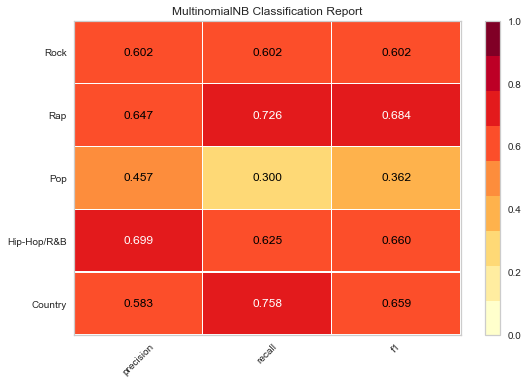

In [6]:
visualizer = ClassificationReport(text_clf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

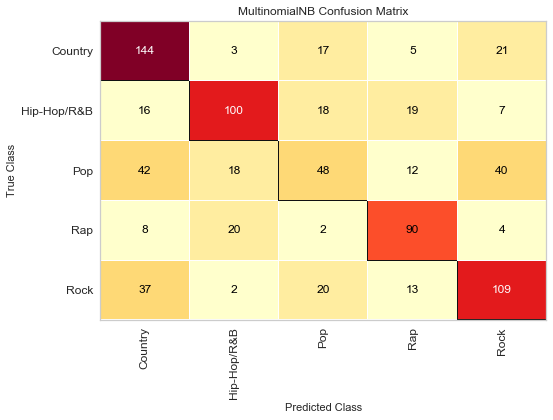

In [7]:
visualizer = ConfusionMatrix(text_clf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [8]:
# Train Multinomial NB model using GridSearch
parameters = {'vect__ngram_range': [(1, 1)],
              'clf__alpha': (1e-2, 1e-3), }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)

#gs_clf.best_score_
gs_clf.best_params_
gs_clf.best_score_

model_score.append(('GridSearch Multi NB', gs_clf.best_score_))

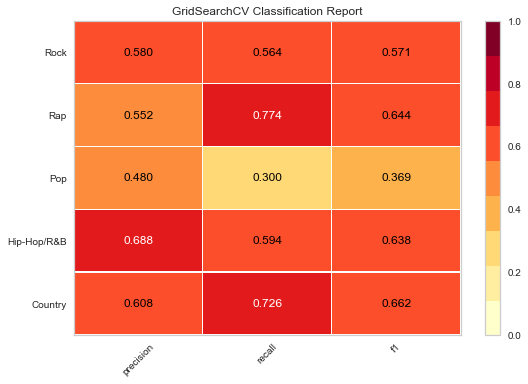

In [9]:
# Define and Plot Confusion Matrix
visualizer = ClassificationReport(gs_clf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

0.5877300613496933

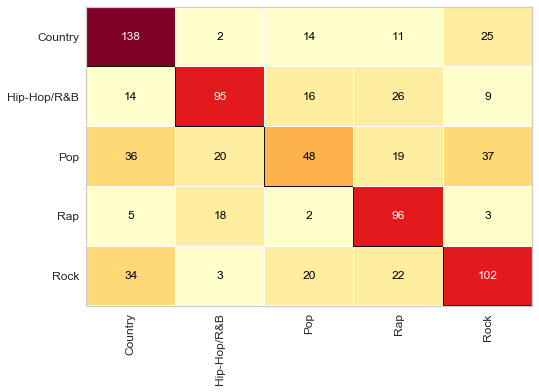

In [10]:
visualizer = ConfusionMatrix(gs_clf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data

In [11]:
# In the pop-up gui window download "all"

#import nltk
#nltk.download()

stop = list(set(stopwords.words('english'))) # stopwords
wnl = WordNetLemmatizer() # lemmatizer

# Explore different hyperparameters with the hopes of improving performance


def tokenizer(x):
    return (
        wnl.lemmatize(w)
        for w in word_tokenize(x)
        if len(w) > 2 and w.isalnum() # only words that are > 3 characters and is alpha-numeric
    )                              
    

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer(
        ngram_range=(1, 1), 
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1, fit_prior=False))])

# train our model on training data
text_clf.fit(X_train, y_train)  

# score our model on testing data
predicted = text_clf.predict(X_test)
score = np.mean(predicted == y_test)

model_score.append(('Tokenized Multi NB', score))


/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


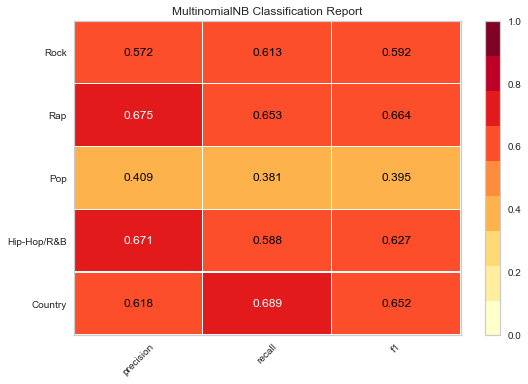

In [12]:
# Define and Plot Confusion Matrix
visualizer = ClassificationReport(text_clf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

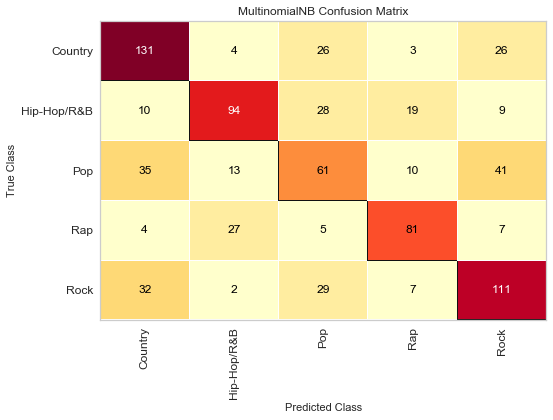

In [13]:
visualizer = ConfusionMatrix(text_clf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [14]:
# Train Multinomial NB model using GridSearch
parameters = {'vect__ngram_range': [(1, 1)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(X_train, y_train)

#gs_clf.best_score_
gs_clf.best_params_
gs_clf.best_score_

model_score.append(('GridSearch Tokenized Multi NB', gs_clf.best_score_))

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


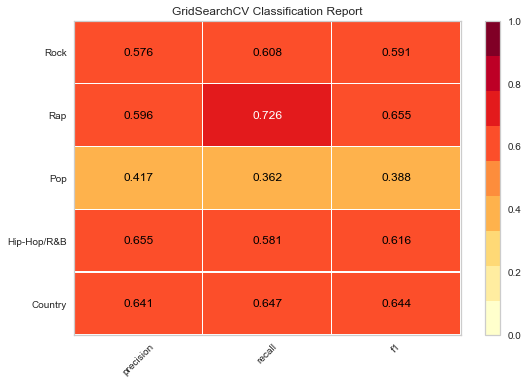

In [15]:
# Define and Plot Confusion Matrix
visualizer = ClassificationReport(gs_clf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


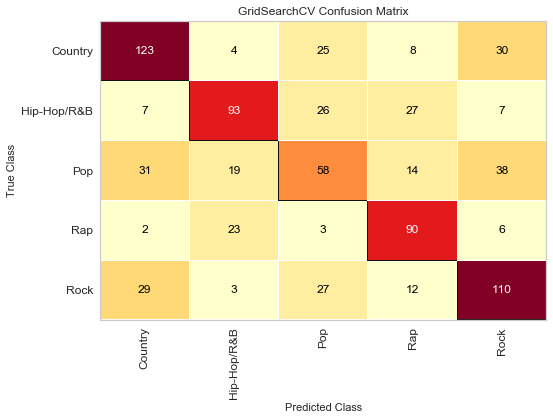

In [16]:
visualizer = ConfusionMatrix(gs_clf)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

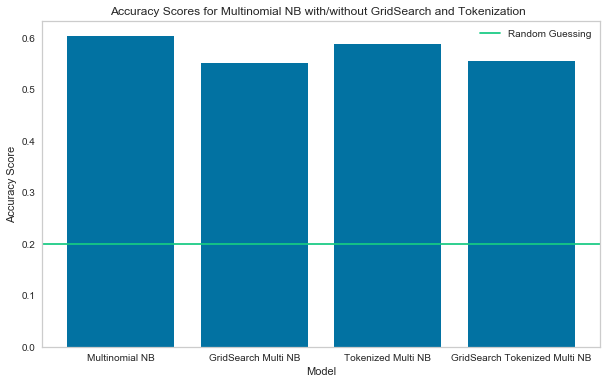

In [17]:
models = [item[0] for item in model_score]
scores = [item[1] for item in model_score]
y = data['Genre']

plt.figure(figsize=(10,6))
plt.title("Accuracy Scores for Multinomial NB with/without GridSearch and Tokenization  ")
plt.grid(False)
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.bar(models, scores)
plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
plt.legend()
